In [2]:
%load_ext cython
import numpy as np
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import Code_for_cluster.cython_code.analyse_sequence as an
import ccmpred.raw
import utility as uti
import seaborn as sns

cmaps_sns = sns.color_palette("colorblind", 10)
l_AF = [0, 3, 2, 8, 1, 4, 5, 6, 7, 9]
cmaps = []
for i in l_AF:
    cmaps.append(cmaps_sns[i])
sns.set_theme(context='notebook', style='ticks', palette=cmaps, color_codes=True, rc=None)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "arial",
    # Use 10pt font in plots, to maT_ch 10pt font in document
    "font.size": 10,
    "axes.titlesize" : 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth" : 1.3,
    'axes.linewidth' : 1,
}
plt.rcParams.update(tex_fonts)

def dictionnary_species(file= "Concat_nnn_extr_withFirst.fasta"):
    """
    return d_species
    """
    d_species = {}
    msa = []
    for ind,record in enumerate(SeqIO.parse(file , "fasta")):     
        msa.append(record.seq)
        name = record.id[record.id.find('|')+1:]
        name = name[:name.find('|')]
        if name not in d_species.keys():
             d_species[name] = [ind]
        else:
            d_species[name].append(ind)
    print(ind)
    return d_species

def convert_msa_number(file,order_amino):
    msa=[]
    for record in SeqIO.parse(file, "fasta"):
        l=[]
        for amino in record.seq:
            index = order_amino.find(amino)
            l.append(index)
        msa.append(l)    
    return np.array(msa,dtype=np.int8)

           
order_amino_CCMGEN = "ARNDCQEGHILKMFPSTWYV-"
order_amino_bmDCA = "-ACDEFGHIKLMNPQRSTVWY"
order_amino_arDCA = "ACDEFGHIKLMNPQRSTVWY-"
file = "Code_for_cluster/fasta_file/Concat_nnn_withFirst.fasta"
file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_no_phylo.fas"

msa_compar_bmDCA = np.unique(convert_msa_number(file,order_amino_bmDCA),axis=0)
msa_compar_arDCA = np.unique(convert_msa_number(file,order_amino_arDCA),axis=0)
msa_compar_CCMGEN = np.unique(convert_msa_number(file,order_amino_CCMGEN),axis=0)

msa_ccmpred = convert_msa_number(file_ccmpred,order_amino_CCMGEN)
msa_no_phylo_bmDCA = np.load("Code_for_cluster/data_bmdca/msa_no_phylo_bmdca.npy")
msa_no_phylo_arDCA = np.load("Code_for_cluster/data_ardca/msa_no_phylo_ardca.npy")

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [3]:
pseudocount = 0
theta = 0.2
n_states = 21

Fij_ardca,_ = an.two_body_freq_cython(msa_no_phylo_arDCA,pseudocount,n_states,0)
Fij_ccmpred,_ = an.two_body_freq_cython(msa_ccmpred,pseudocount,n_states,0)
Fij_bmdca,_ = an.two_body_freq_cython(msa_no_phylo_bmDCA,pseudocount,n_states,0)

Fij_in_ardca,_ = an.two_body_freq_cython(msa_compar_arDCA,pseudocount,n_states,theta)
Fij_in_bmdca,_ = an.two_body_freq_cython(msa_compar_bmDCA,pseudocount,n_states,theta)
Fij_in_ccmpred,weight = an.two_body_freq_cython(msa_compar_CCMGEN,pseudocount,n_states,theta)

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def func(x, a, b):
    return a + b*x
x=np.linspace(0,1)

def one_freq(Fij):
    Fi = np.zeros((Fij.shape[0],Fij.shape[1]))
    for site in range(Fi.shape[0]):
        for sp in range(Fi.shape[1]):
            Fi[site,sp] = Fij[site,sp,site,sp]
    return Fi

def polt_two_one_freq(Fij_ref, Fij_calc, title="", width="article"):
    figsize = uti.set_size(width,subplots=(1,2))
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    r,_ = pearsonr(Fij_ref.flatten(), Fij_calc.flatten())
    popt, pcov = curve_fit(func, Fij_ref.flatten(), Fij_calc.flatten())
    plt.scatter(Fij_ref.flatten(),Fij_calc.flatten(),s=1)
    plt.plot(x,x,color="black")
    plt.title("Two-body frequencies $F_{i,j}(a_i,a_j)$ \n a+b*x:" + str(np.round(popt,2)) + "\n pearson = " + str(np.round(r,2)))
    plt.xlabel("Frequences in weighted original data")
    plt.ylabel("Frequences in generated data")
    plt.subplot(1,2,2)
    Fi_ref = one_freq(Fij_ref)   
    Fi_calc = one_freq(Fij_calc)
    r,_ = pearsonr(Fi_ref.flatten(), Fi_calc.flatten())
    popt, pcov = curve_fit(func, Fi_ref.flatten(), Fi_calc.flatten())
    plt.scatter(Fi_ref.flatten(),Fi_calc.flatten(),s=1)
    plt.plot(x,x,color="black")
    plt.xlabel("Frequences in weighted original data")
    #plt.ylabel("Frequences in generated data")
    plt.title("One-body frequencies $F_i(a_i)$ \n a+b*x:" + str(np.round(popt,4)) + "\n pearson = " + str(np.round(r,2)))
    plt.suptitle(title)

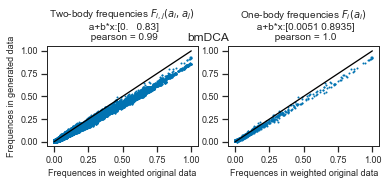

In [5]:
polt_two_one_freq(Fij_in_bmdca, Fij_bmdca, title="bmDCA")
#plt.savefig("figures/Two_One_frequencies_bmdca.eps")

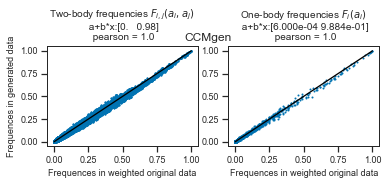

In [6]:
polt_two_one_freq(Fij_in_ccmpred, Fij_ccmpred, title="CCMgen")
#plt.savefig("figures/Two_One_frequencies_ccmgen.eps")

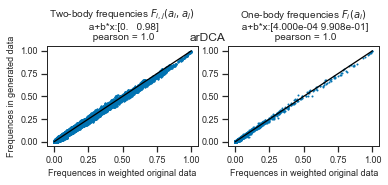

In [7]:
polt_two_one_freq(Fij_in_ardca, Fij_ardca, title="arDCA")
#plt.savefig("figures/Two_One_frequencies_ardca.eps")

In [8]:
def polt_two_l_freq(l_Fij_ref, l_Fij_calc, l_title=None, width="article"):
    figsize = uti.set_size(width,subplots=(1,len(l_Fij_calc)))
    fig, ax =  plt.subplots(figsize=figsize, ncols=len(l_Fij_calc), nrows=1)
    x=np.linspace(0,1)
    for i in range(ax.shape[0]):
        Fij_calc = l_Fij_calc[i]
        Fij_ref = l_Fij_ref[i]
        r,_ = pearsonr(Fij_ref.flatten(), Fij_calc.flatten())
        popt, pcov = curve_fit(func, Fij_ref.flatten(), Fij_calc.flatten())
        ax[i].plot(Fij_ref.flatten(), Fij_calc.flatten(), ls="", marker = ".", markersize=0.01, color=cmaps[0])
        ax[i].plot(x, x, color="black")
        if l_title is not None:
            ax[i].set_title(l_title[i] +"\n a+b*x:" + str(np.round(popt,2)) + "\n pearson = " + str(np.round(r,4)))
        if i==0:
            ax[i].set_xlabel("Frequences in weighted original data")
            ax[i].set_ylabel("Frequences in generated data")
        if i!=0:
            ax[i].axes.yaxis.set_ticklabels([])
    #fig.savefig("figures/2_body_frequencies.eps",bbox_inches = "tight", dpi=500)

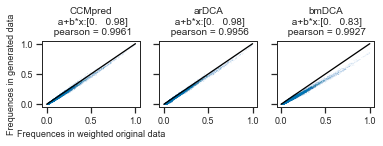

In [9]:
l_Fij_calc = [Fij_ccmpred, Fij_ardca, Fij_bmdca]
l_Fij_ref = [Fij_in_ccmpred, Fij_in_ardca, Fij_in_bmdca]
l_title = ["CCMpred","arDCA","bmDCA"]
polt_two_l_freq(l_Fij_ref, l_Fij_calc, l_title=l_title, width="article")


In [10]:
%%cython
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
# cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False

import numpy as np
cimport cython
from cython.parallel import prange

def image_plot_freq(double[::1,:,:,:] freqs1, double[::,:,:,:] freqs2, int val=1000, double xmin=0, double xmax=1):
    cdef:  
        int[:,::1] ima = np.zeros((val,val), dtype=np.intc)
        int i,j,k,l,pos1,pos2
        
    #assert freqs1.shape == freqs2.shape
    #assert len(freqs1.shape) == 4
    
    for i in prange(freqs1.shape[0], nogil=True):
        for j in range(freqs1.shape[1]):
            for k in range(freqs1.shape[2]):
                for l in range(freqs1.shape[3]):
                    pos1 = freq_to_pos(freqs1[i,j,k,l], val, xmin, xmax)
                    pos2 = freq_to_pos(freqs2[i,j,k,l], val, xmin, xmax)
                    ima[pos1,pos2] += 1
    
    return np.asarray(ima)
    
    
cdef int freq_to_pos(double freq, int val, double xmin, double xmax) nogil:
    return int((val-1)/(xmax-xmin)*freq)

In [11]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import matplotlib.colors as colors

def func(x, a, b):
    return a + b*x


def polt_two_l_freq_im(l_Fij_ref, l_Fij_calc, l_title=None, width="article"):
    figsize = uti.set_size(width,subplots=(1,len(l_Fij_calc)))
    fig, ax =  plt.subplots(figsize=figsize, ncols=len(l_Fij_calc), nrows=1)
    ext = [0, 1, 0, 1]
    l_hh = [image_plot_freq(l_Fij_ref[i], l_Fij_calc[i], val=100) for i in range(len(l_Fij_ref))]
    norm = colors.LogNorm(vmin=1, vmax=(max([l_hh[i].max() for i in range(len(l_hh))])))
    
    for i in range(ax.shape[0]):
        Fij_calc = l_Fij_calc[i]
        Fij_ref = l_Fij_ref[i]
        r,_ = pearsonr(Fij_ref.flatten(), Fij_calc.flatten())
        popt, pcov = curve_fit(func, Fij_ref.flatten(), Fij_calc.flatten())
        if l_title:
            print(l_title[i] +"\n a+b*x:" + str(np.round(popt,2)) + "\n pearson = " + str(np.round(r,4)))
            
        pcm = ax[i].imshow(l_hh[i].T,
                      extent=ext,
                      aspect="auto",
                      origin='lower',
                      norm=norm)
        
        ax[i].plot(ext[0:2], ext[2:], 'g--', linewidth=1)

        if l_title is not None:
            ax[i].set_title(l_title[i])
        if i==0:
            ax[i].set_ylabel("$f_{ij}(\\alpha_i,\\alpha_j)$ in generated data")
            ax[i].set_xlabel("$f_{ij}(\\alpha_i,\\alpha_j)$ in weighted natural data")
            ax[i].xaxis.set_label_coords(1, -0.2)
        if i!=0:
            ax[i].axes.yaxis.set_ticklabels([])
        

    cbar = fig.colorbar(pcm, ax=ax.flatten(), label="Counts")
    fig.savefig("figures/S8_2_body_frequencies_images.png", dpi=1000, bbox_inches="tight")

A: bmDCA
 a+b*x:[0.   0.83]
 pearson = 0.9927
B: arDCA
 a+b*x:[0.   0.98]
 pearson = 0.9956


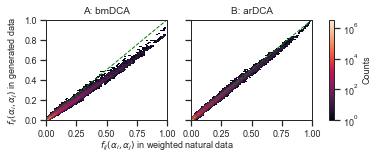

In [12]:
l_Fij_ref = [Fij_in_bmdca, Fij_in_ardca]
l_Fij_calc = [Fij_bmdca, Fij_ardca]
l_title = ["A: bmDCA","B: arDCA"]
polt_two_l_freq_im(l_Fij_ref, l_Fij_calc, l_title=l_title, width="article")

## Meff

In [13]:
%%cython
# cython: language_level=3,  boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp
cimport cython
from cython.parallel import prange
import numpy as np 

cpdef double compute_Meff(char[:,::1] msa, double theta):
    cdef:
        double[::1] sum_dist = np.zeros((msa.shape[0]))
        double Meff = 0.0
        int i,j
    if theta>0:
        with nogil:
            for i in prange(msa.shape[0]-1,schedule = "dynamic"):
                for j in range(i+1,msa.shape[0]):
                    if hamming_dist(msa[i],msa[j])<theta:
                        sum_dist[i] += 1
                        sum_dist[j] += 1
    for i in range(msa.shape[0]):
        Meff += 1/(sum_dist[i]+1) #dont take into account the diagonal
    return Meff

cdef inline double hamming_dist(char[::1] a, char[::1] b) nogil:
    cdef:
        int i
        double dist = 0.0
    for i in range(a.shape[0]):
        dist+= (a[i]!=b[i])*1.0
    return dist/a.shape[0]

In [14]:
order_amino_CCMGEN = "ARNDCQEGHILKMFPSTWYV-"
order_amino_bmDCA = "-ACDEFGHIKLMNPQRSTVWY"
order_amino_arDCA = "ACDEFGHIKLMNPQRSTVWY-"
file = "Code_for_cluster/fasta_file/Concat_nnn_withFirst.fasta"

msa_real_data = convert_msa_number(file,order_amino_bmDCA)
msa_real_data_unique = np.unique(convert_msa_number(file,order_amino_bmDCA),axis=0)

file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_no_phylo.fas"
msa_no_phylo_ccmpred = convert_msa_number(file_ccmpred,order_amino_CCMGEN)
msa_no_phylo_bmDCA = np.load("Code_for_cluster/data_bmdca/msa_no_phylo_bmdca.npy")
msa_no_phylo_arDCA = np.load("Code_for_cluster/data_ardca/msa_no_phylo_ardca.npy")

file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_phylo_fast_tree_random_mutation_rate_1.fas"
msa_ccmpred_tree_random_mutation_rate_1 = convert_msa_number(file_ccmpred,order_amino_CCMGEN)
msa_tree_random_bmDCA = np.load("Code_for_cluster/data_bmdca/msa_phylo_bmdca_tree.npy")
msa_tree_random_arDCA = np.load("Code_for_cluster/data_ardca/msa_phylo_ardca_tree.npy")

file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_phylo_fast_tree_equi_mutation_rate_1.fas"
msa_ccmpred_tree_equi_mutation_rate_1 = convert_msa_number(file_ccmpred,order_amino_CCMGEN)
msa_tree_equi_bmDCA = np.load("Code_for_cluster/data_bmdca/msa_phylo_equi_bmdca_tree.npy")
msa_tree_equi_arDCA = np.load("Code_for_cluster/data_ardca/msa_phylo_equi_ardca_tree.npy")

file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_phylo_fast_tree_equi_mutation_rate_auto.fas"
msa_ccmpred_tree_equi_auto_mutation_rate = convert_msa_number(file_ccmpred,order_amino_CCMGEN)

file_ccmpred = "Code_for_cluster/data_ccmpred/msa.mcmc_phylo_fast_tree_random_mutation_rate_auto.fas"
msa_ccmpred_tree_random_auto_mutation_rate = convert_msa_number(file_ccmpred,order_amino_CCMGEN)


In [15]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

l_msa = [msa_real_data,msa_real_data_unique,msa_no_phylo_ccmpred,msa_no_phylo_bmDCA,msa_no_phylo_arDCA,
        msa_ccmpred_tree_random_mutation_rate_1,msa_tree_random_bmDCA,msa_tree_random_arDCA,
        msa_ccmpred_tree_equi_mutation_rate_1,msa_tree_equi_bmDCA,msa_tree_equi_arDCA,
         msa_ccmpred_tree_random_auto_mutation_rate, msa_ccmpred_tree_equi_auto_mutation_rate
        ]
theta = 0.2
print("theta = %s"%theta)
l_meff = []
for msa in l_msa:
    l_meff.append(compute_Meff(msa,theta))
    print("Meef %s = %s"%(namestr(msa,globals())[0], l_meff[-1]))

theta = 0.2
Meef msa_real_data = 7512.503894424569
Meef msa_real_data_unique = 7519.828943985869
Meef msa_no_phylo_ccmpred = 24000.0
Meef msa_no_phylo_bmDCA = 23633.0
Meef msa_no_phylo_arDCA = 23633.0
Meef msa_ccmpred_tree_random_mutation_rate_1 = 6146.369721612461
Meef msa_tree_random_bmDCA = 8949.324231388444
Meef msa_tree_random_arDCA = 8953.62733174349
Meef msa_ccmpred_tree_equi_mutation_rate_1 = 4275.0113168326025
Meef msa_tree_equi_bmDCA = 8474.949158396363
Meef msa_tree_equi_arDCA = 8412.997422926728
Meef msa_ccmpred_tree_random_auto_mutation_rate = 5111.70768711693
Meef msa_ccmpred_tree_equi_auto_mutation_rate = 12300.153773180566


Text(0, 0.5, 'Meff')

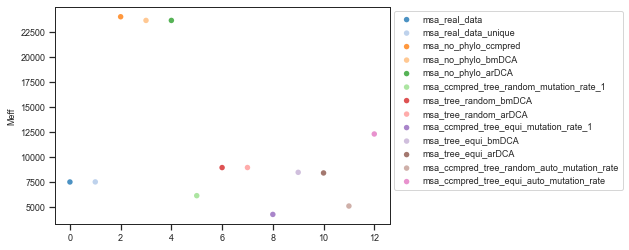

In [16]:
cmaps = plt.get_cmap("tab20")
bars =  [namestr(msa,globals())[0] for msa in l_msa]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


for i,meff in enumerate(l_meff):
    ax.scatter(i, meff, alpha=0.8, color=cmaps(i),edgecolors='none', s=30, label=bars[i])
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Meff")
#plt.savefig("figures/Meef_for_all_data.eps",bbox_inches = "tight")